In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from datetime import date
import tkinter.messagebox as mbox

from bs4 import BeautifulSoup
import time
from selenium import webdriver
from urllib.parse import urljoin

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 20:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [3]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [4]:
def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #link
    news_headline = news_tag.find('a').text #heading
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'content' : news_content,
           }

In [5]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [6]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [7]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

from transformers import pipeline

In [8]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Ticker

In [9]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [10]:
text_input = input("Type in the Ticker: ")
print("You entered:", text_input)

#text_input = 'xom'

You entered: SPY


# Yahoo Finance News

In [11]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = f'https://finance.yahoo.com/quote/{text_input}?p={text_input}&.tsrc=fin-srch'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2023-04-13
Report Time = 08:38:10


In [12]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [13]:
#news_df[news_df['Score'] > 0.8] 
news_df2 = news_df[news_df['Score'] > 0.8] [news_df[news_df['Score'] > 0.8] ['Score2'] > 0.8]

In [14]:
news_df2.head(20)

,source,time,headline,content,Sentiment,Score,Sentiment2,Score2
0,Zacks,yesterday,Should SPDR S&P 500 ETF (SPY) Be on Your Investing Radar?,Style Box ETF report for SPY,NEGATIVE,0.998921,NEGATIVE,0.931347
2,The Wall Street Journal,7 days ago,"Options Investors Face Challenges in a Volatile, but Flat, Stock Market",The lack of a sustained move up or down in the market increases the likelihood that options contracts will expire worthless,NEGATIVE,0.998616,NEGATIVE,0.999663
3,Zacks,7 days ago,"Jobless Claims Makeover: 228K, 200K+ for 8 Weeks",Seasonal adjustments now show we've been above 200K new claims for the past eight weeks.,NEGATIVE,0.988532,NEGATIVE,0.975258
4,Motley Fool,8 days ago,Could This Alternative S&P 500 Index ETF Make You More Money Than the Most Popular ETFs?,"Is investing in index exchange-traded funds (ETFs) boring? Actually, an S&P 500 index fund offers a great way to retire as a millionaire. Two S&P 500 ETFs -- SPDR S&P 500 ETF Trust (NYSEMKT: SPY) and Vanguard 500 Index Fund ETF (NYSEMKT: VOO) -- are by far the most widely traded.",NEGATIVE,0.999154,NEGATIVE,0.808636
7,Yahoo Finance,13 days ago,The first quarter of the year sent investors back to the future: Morning Brief,"The tech sector's current boom feels like 2021, but there's a ton of differences between then and now.",NEGATIVE,0.970662,NEGATIVE,0.927400
8,ETF.com,14 days ago,Tech Charges QQQ as Nasdaq Enters Bull Market,The ETF’s 20% surge from its December low handily beats the broader market.,NEGATIVE,0.997395,POSITIVE,0.998760
9,Zacks,14 days ago,Q4 GDP Ticks Down to +2.6%; Jobless Claims Stay Low,"Year over year GDP for 2022 comes in at +3.9%, 200 bps lower than the very strong 2021, which provided the Great Reopening from the Covid pandemic.",NEGATIVE,0.998402,NEGATIVE,0.989929
10,Zacks,14 days ago,Defined Outcome ETF (BALT) Hits New 52-Week High,This defined outcome ETF hits a new 52-week high. Are more gains in store for this ETF?,POSITIVE,0.892606,NEGATIVE,0.856478
11,ETF.com,16 days ago,"ETFs Lost Assets Last Month, While Active Funds Grabbed Share","Wavering markets, rising inflation pushed investors toward active products.",NEGATIVE,0.998937,NEGATIVE,0.952135
12,Yahoo Finance,17 days ago,Charts: Three key readings to track financial market stress,"A bank crisis has pressured financial markets and made it hard for investors to know where to turn for signs of stability or worry. A few key readings on volatility, the bond market, and the currency market offer some guidance.",POSITIVE,0.970314,NEGATIVE,0.995688


In [15]:
text_input2 = input("How many rows of news?: ")
text_input2 = int(text_input2)

# Sentiment

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

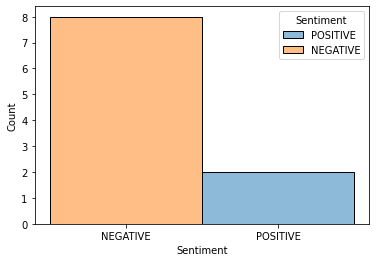

In [16]:
sns.histplot(x = 'Sentiment', data = news_df2[:text_input2], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

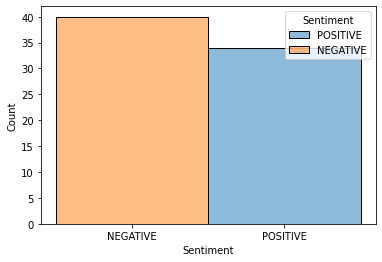

In [17]:
sns.histplot(x = 'Sentiment', data = news_df2, hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# Headline Trigram

In [18]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["headline"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Content Trigram

In [19]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Finviz

In [20]:
url = f"https://finviz.com/quote.ashx?t={text_input}&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [21]:
df = pd.DataFrame(sentence2)

In [22]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [23]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [24]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [25]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

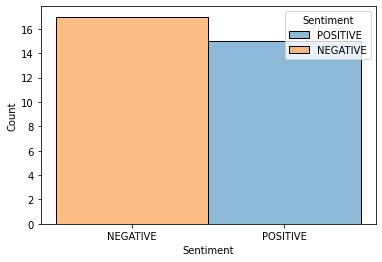

In [26]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

In [27]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df["Headline_Lower"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Forecast

In [28]:
#Past 3 year data
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=1095), end=dt.date.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [29]:
start_time = pd.Timestamp(df['Date'][0])
end_time = pd.Timestamp(df['Date'][len(df)-1])
time_range = pd.date_range(start_time, end_time, freq=df['Date'][1] - df['Date'][0] )

time_list = time_range.tolist()


time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Date'])
df_dates['Date'] = time_list

#Ensure all reading time exists, fill with 0 for missing reading times
df = pd.merge(df, df_dates, on='Date', how='right')

df.fillna(method='ffill', inplace=True)

In [30]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Date', y = 'Close', data = df)
# plt.show()

In [31]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=365, include_history=False)

# Make predictions for future dates
forecast = model.predict(future_dates)

08:39:42 - cmdstanpy - INFO - Chain [1] start processing
08:39:42 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# One Year Outlook

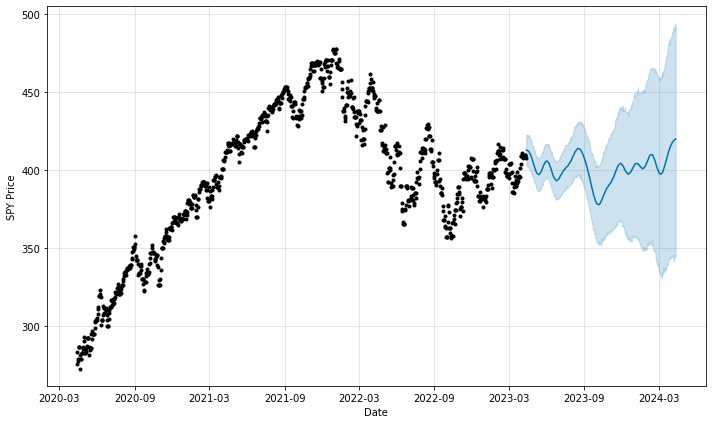

(18730.0, 19825.0)

(300.83059836823776, 501.38433061372956)

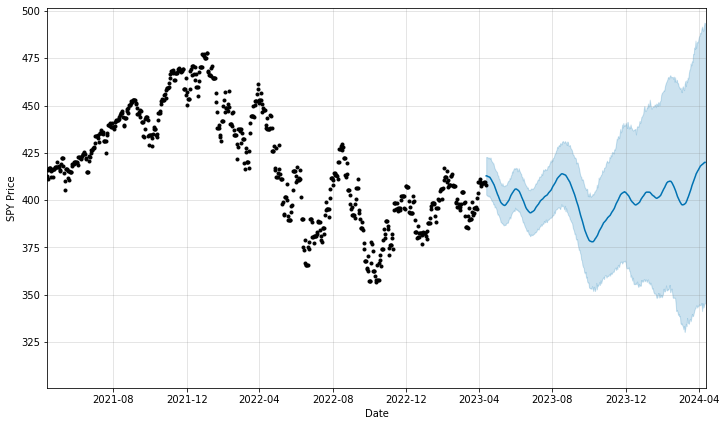

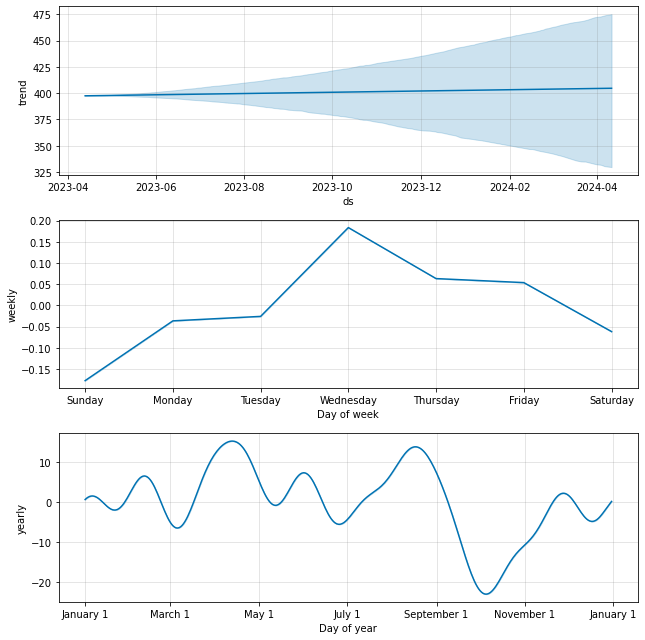

In [33]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=730), dt.date.today() + dt.timedelta(days=365))
plt.ylim(forecast['yhat'].mean()*0.75, forecast['yhat'].mean()*1.25)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [34]:
#Past 1 year data
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=365), end=dt.date.today())
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [35]:
start_time = pd.Timestamp(df1['Date'][0])
end_time = pd.Timestamp(df1['Date'][len(df1)-1])
time_range = pd.date_range(start_time, end_time, freq=df1['Date'][1] - df1['Date'][0] )

time_list = time_range.tolist()


time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Date'])
df_dates['Date'] = time_list

#Ensure all reading time exists, fill with 0 for missing reading times
df1 = pd.merge(df1, df_dates, on='Date', how='right')

df1.fillna(method='ffill', inplace=True)

In [36]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [37]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Date', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=30, include_history=False)

# Make predictions for future dates
forecast = model.predict(future_dates)


08:39:45 - cmdstanpy - INFO - Chain [1] start processing
08:39:45 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# 30 Days Outlook

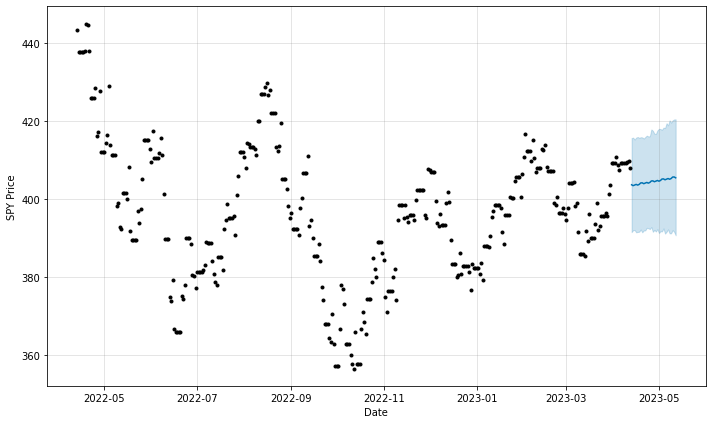

(19400.0, 19490.0)

(364.11597109492646, 445.03063133824344)

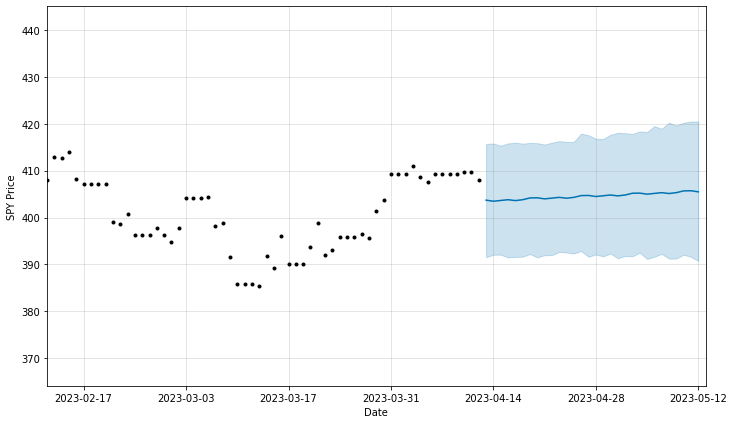

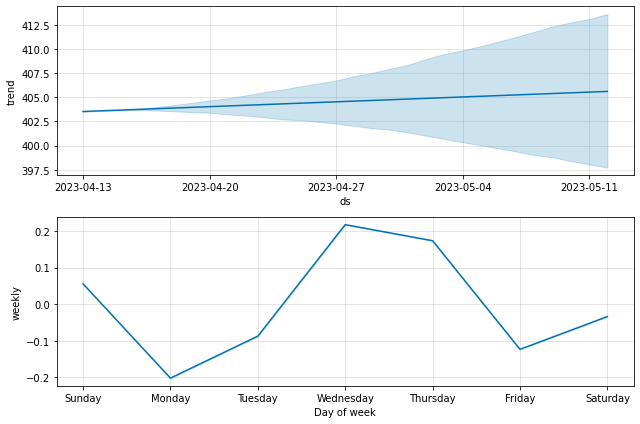

In [39]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=60), dt.date.today() + dt.timedelta(days=30))
plt.ylim(forecast['yhat'].mean()*0.9, forecast['yhat'].mean()*1.1)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [40]:
#Past week data
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [41]:
start_time = pd.Timestamp(df1['Datetime'][0])
end_time = pd.Timestamp(df1['Datetime'][len(df1)-1])
time_range = pd.date_range(start_time, end_time, freq=df1['Datetime'][1] - df1['Datetime'][0] )

time_list = time_range.tolist()

In [42]:
time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Datetime'])
df_dates['Datetime'] = time_list

In [43]:
#Ensure all reading time exists, fill with 0 for missing reading times
df1 = pd.merge(df1, df_dates, on='Datetime', how='right')

In [44]:
df1.fillna(method='ffill', inplace=True)

In [45]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [46]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2880, freq='T', include_history=False)


# Make predictions for future dates
forecast = model.predict(future_dates)


08:39:47 - cmdstanpy - INFO - Chain [1] start processing
08:39:55 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# One Day Outlook

In [49]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-12 16:01:00,409.714912,409.427907,410.264097,409.714912,409.714912,0.135216,0.135216,0.135216,0.135216,0.135216,0.135216,0.0,0.0,0.0,409.850128
1,2023-04-12 16:02:00,409.714803,409.427920,410.288409,409.714803,409.714803,0.131825,0.131825,0.131825,0.131825,0.131825,0.131825,0.0,0.0,0.0,409.846628
2,2023-04-12 16:03:00,409.714694,409.419691,410.272275,409.714694,409.714694,0.128439,0.128439,0.128439,0.128439,0.128439,0.128439,0.0,0.0,0.0,409.843132
3,2023-04-12 16:04:00,409.714584,409.393488,410.249665,409.714584,409.714584,0.125057,0.125057,0.125057,0.125057,0.125057,0.125057,0.0,0.0,0.0,409.839641
4,2023-04-12 16:05:00,409.714475,409.404392,410.256622,409.714475,409.714475,0.121681,0.121681,0.121681,0.121681,0.121681,0.121681,0.0,0.0,0.0,409.836156


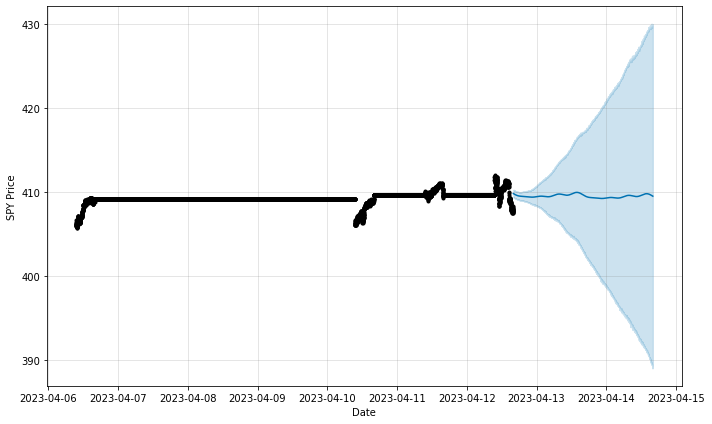

(19458.0, 19461.0)

(401.36644689559193, 417.74875085051406)

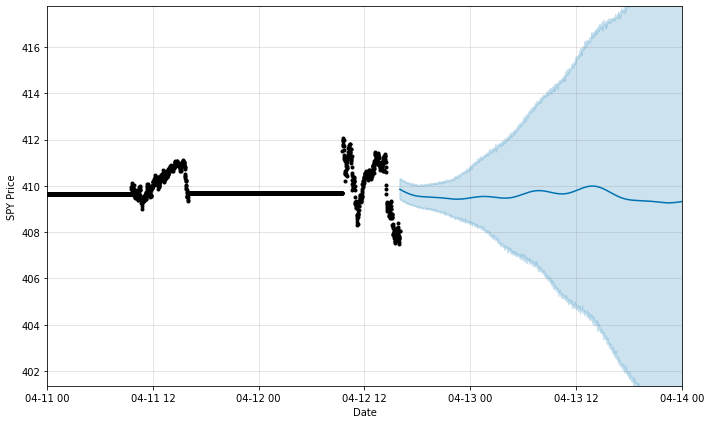

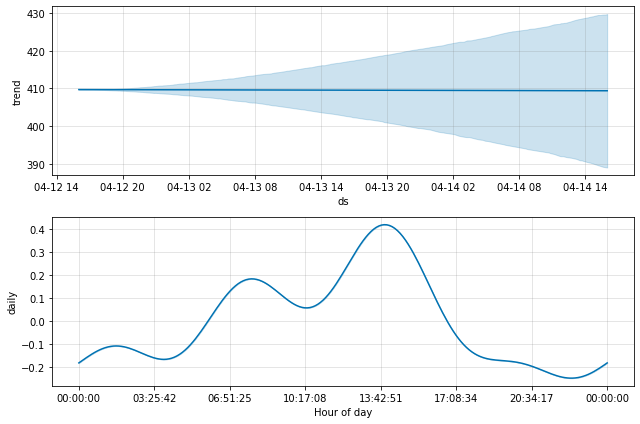

In [48]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=2), dt.date.today() + dt.timedelta(days=1))
plt.ylim(forecast['yhat'].mean()*0.98, forecast['yhat'].mean()*1.02)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()